In [1]:
pip install pycbc

In [6]:
import matplotlib.pyplot as plt
from pycbc.detector import Detector
import numpy as np
from itertools import combinations
import pandas as pd
from pycbc.waveform import get_fd_waveform
from pycbc.psd import aLIGOZeroDetHighPower

n=10000

ra = np.random.uniform(0,2*np.pi,n)
dec = np.pi/2 - np.arccos(np.random.uniform(-1,1,n))

pol = 0
t = 1e10

#LIGO India
class LigoIndia(Detector):
    def __init__(self, name, latitude, longitude, orientation):
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.orientation = orientation
        super().__init__(name)
ligo_india_latitude = np.radians(19.613306)
ligo_india_longitude = np.radians(77.030861)
ligo_india_orientation = np.radians(45.0)

detectors = [Detector("L1"),Detector("H1"),Detector("K1"),Detector("V1"),
             LigoIndia("I1", ligo_india_latitude, ligo_india_longitude, ligo_india_orientation)]




## SNR

In [7]:
delta_f = 1.0 / 4
f_lower = 20
distance = 900  # Mpc
mass1 = 1.5
mass2 = 1.5

d = Detector("H1")
fp_vals, fc_vals = d.antenna_pattern(ra, dec, pol, t)
proj_vals = fp_vals**2 + fc_vals**2

# Get index of most sensitive direction
idx_best = np.argmax(proj_vals)
ra_best = ra[idx_best]
dec_best = dec[idx_best]
fp_best = fp_vals[idx_best]
fc_best = fc_vals[idx_best]
proj_best = proj_vals[idx_best]

inclinations = np.linspace(0, 2*np.pi, 200)
rhos = []

for iota in inclinations:
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                             mass1=mass1, mass2=mass2,
                             f_lower=f_lower,
                             delta_f=delta_f,
                             inclination=iota,
                             distance=distance)

    H_sq = abs(hp)**2 + abs(hc)**2
    psd = aLIGOZeroDetHighPower(len(hp), delta_f, 0.0)
    valid = psd > 0
    rho_sq = ((H_sq[valid] / psd[valid]) * delta_f).sum()
    rho = np.sqrt(2 * proj_best * rho_sq)
    rhos.append(rho)




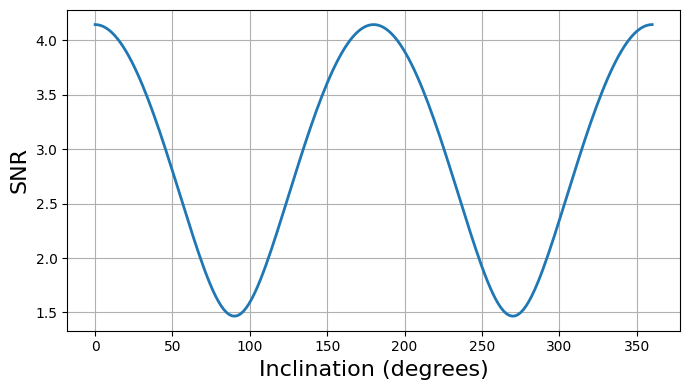

In [8]:
plt.figure(figsize=(7, 4))
plt.plot(np.degrees(inclinations), rhos, lw=2)
plt.xlabel("Inclination (degrees)",size=16)
plt.ylabel("SNR",size=16)
#plt.title("Inclination vs SNR (at Most Sensitive Sky Location)")
plt.grid(True)
plt.tight_layout()
plt.savefig('snr-inclination.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
from google.colab import files
files.download('snr-inclination.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Sky Coverage

In [11]:
rho_min = 8.0

detector = Detector("L1")
fp, fc = detector.antenna_pattern(ra, dec, pol, t)

inclinations = np.linspace(0, 2 * np.pi, 10000)
sky_coverages = []

for incl in inclinations:
    hp, hc = get_fd_waveform(
        approximant="TaylorF2",
        mass1=5,
        mass2=10,
        f_lower=20,
        delta_f=1.0 / 16,
        distance=1500,
        inclination=incl
    )

    H_f_squared = np.abs(hp) ** 2 + np.abs(hc) ** 2
    psd = aLIGOZeroDetHighPower(len(hp), hp.delta_f, 0.0)
    valid = psd > 0
    rho_sq_source = ((H_f_squared[valid] / psd[valid]) * hp.delta_f).sum()

    rho_sq_total = 2 * (fp**2 + fc**2) * rho_sq_source
    rho = np.sqrt(rho_sq_total)

    sky_coverage = 100.0 * np.mean(rho > rho_min)
    sky_coverages.append(sky_coverage)

inclinations_deg = np.degrees(inclinations)




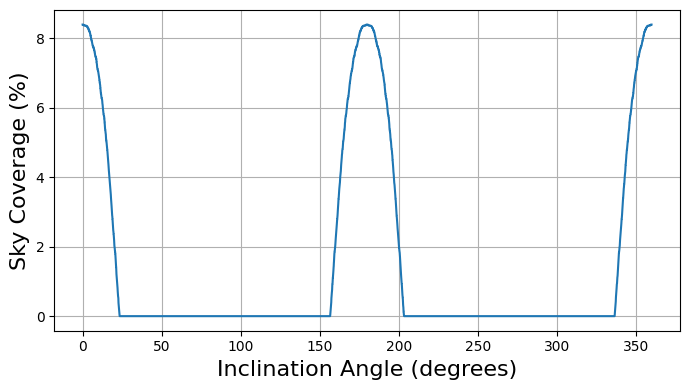

In [12]:
plt.figure(figsize=(7, 4))
plt.plot(inclinations_deg, sky_coverages, marker='', linestyle='-')
plt.xlabel("Inclination Angle (degrees)",size=16)
plt.ylabel("Sky Coverage (%)",size=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('sc-inclination.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
from google.colab import files
files.download('sc-inclination.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Mean Horizon Distance

In [16]:
proj_vals = fp_vals**2 + fc_vals**2

inclinations = np.linspace(0, 2*np.pi, 1000)
mean_reaches = []

for iota in inclinations:
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                             mass1=mass1, mass2=mass2,
                             f_lower=f_lower, delta_f=delta_f,
                             inclination=iota,
                             distance=distance)

    H_sq = abs(hp)**2 + abs(hc)**2
    psd = aLIGOZeroDetHighPower(len(hp), delta_f, 0.0)
    valid = psd > 0
    rho_sq = ((H_sq[valid] / psd[valid]) * delta_f).sum()

    rho_sq_total = 2 * proj_vals * rho_sq
    rho_total = np.sqrt(rho_sq_total)

    reach = distance * (rho_total / rho_min)
    mean_reaches.append(np.mean(reach))





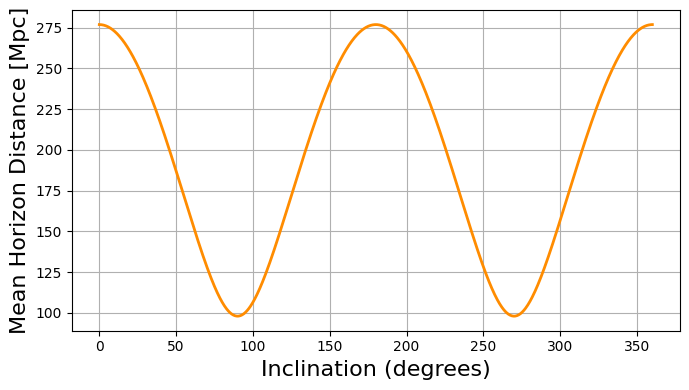

In [17]:
plt.figure(figsize=(7, 4))
plt.plot(np.degrees(inclinations), mean_reaches, lw=2, color='darkorange')
plt.xlabel("Inclination (degrees)",size=16)
plt.ylabel("Mean Horizon Distance [Mpc]",size=16)
#plt.title("Mean Horizon Distance vs Inclination")
plt.grid(True)
plt.tight_layout()
plt.savefig('mhd-inclination.png', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
from google.colab import files
files.download('mhd-inclination.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Detection Volume

In [19]:
proj = 2 * (fp**2 + fc**2)
P = proj / 2

inclinations = np.linspace(0, 2*np.pi, 1000)
volumes = []

for iota in inclinations:
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                             mass1=mass1, mass2=mass2,
                             f_lower=f_lower,
                             delta_f=delta_f,
                             inclination=iota,
                             distance=distance)

    H_sq = abs(hp)**2 + abs(hc)**2
    psd = aLIGOZeroDetHighPower(len(hp), delta_f, 0.0)
    valid = psd > 0
    rho_sq_source = ((H_sq[valid] / psd[valid]) * delta_f).sum()

    rho_sq_total = proj * rho_sq_source
    rho_total = np.sqrt(rho_sq_total)
    reach = distance* (rho_total / rho_min)

    R0 = np.max(reach)
    I = (4 * np.pi) * np.mean(P**(3/2))
    V = (I * R0**3) / 3
    volumes.append(V)

volumes = np.array(volumes)



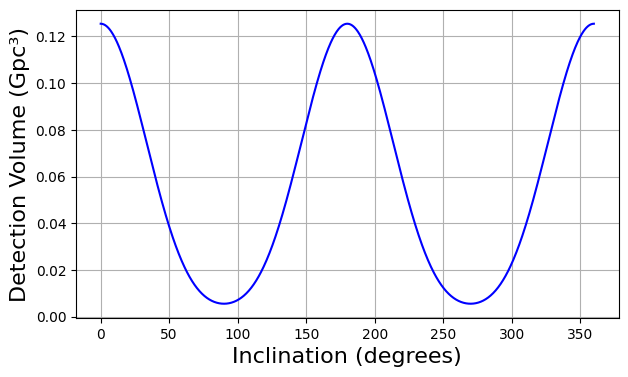

In [22]:

plt.figure(figsize=(7,4))
plt.plot(np.degrees(inclinations), volumes * 1e-9, color='blue')  # Convert volume to Gpc³
plt.xlabel('Inclination (degrees)', size = 16)
plt.ylabel('Detection Volume (Gpc³)',size = 16)
plt.grid(True)
plt.savefig('dv-inclination.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
from google.colab import files
files.download('dv-inclination.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>